<a href="https://colab.research.google.com/github/inforeqd512/QLearning/blob/main/RL_TicTacToe_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [233]:
import numpy as np

# Game

Every simulation starts with a new Game _Board_. 

The simulation ends when the board is full or when one of the players wins.

Every Player is an _Agent_ and is setup with their own _Policy Trainer_ that follows espilon (ε) greedy policy to learn best actions over several iterations of the simulation.

**Measure of success :** The Players become good at playing when the 'Draw' percentages are high.. ie. the players learn to play  to Draw
 
It takes approximately 10000 iterations to get to optimal q-values to get mostly Draws.

**Deterministic MDP, State Value function and After State:** Tic Tac Toe is a deterministic Markov Decision Process. The same action always has same outcome.  Unlike Stochastic ones where same action could have different outcomes based on probability. 

In deterministic MDPs/games, its sufficient to have a state value function only. The reason is that there is only one thing that can happen after you take your action. There is no stochasticity in your environment... no variability in what will happen. If you know the rules of the game and model of the MDP.. step forward once with the model/rules to reach the _afterstate_.

Therefore, do we need an action value function?. Usually when doing value based RL, we need to estimate how good the action is in the absence of knowledge of your environment. In deterministic MDPs, the value of taking action is the same as evaluating the state that you arrive into as there's no where else you could have gone taking that action. State value func is smaller.. no cross product of state and action. 

However for this exercise, since the Q-table for Action Value functions will not be too big, we'll solve using the Action values.. But since we are using Action values, we have to be careful in ensuring that illegal actions do not contribute to the calculation/backpropagation of the q-value. 

**Using Self-Play to arrive at optimal policy :** A single policy used in both players. That policy is improved by two players playing against each other using it. 

**Self-Play is a Simulation based RL approach :** Simulate experiences (markov chains) that starts from _NOW_, learning from the subspace of experiences starting from _NOW_. Repeating thousands of cycles of exp starting from _NOW_. 

Once the reward is received, all intermediate states are updated in that path eg. winner is fed upto all of the positions that led up to that win as so is the loss fed upto all positions that led up to it for the other losing player.

For our games, we start from empty board each time, because the longest markov chain can be only 8 steps. However this can be improved by say, starting the board with the player X starting the play in the middle of the board, running the simulation and then resetting to the same start position for several more such games. This way we can arrive at the value of the 'middle start'. However, we can hypothesise that this is not useful as when the players become really good at their policies (Nash equilibrium) then from any start position, they should be able to reach a draw. TODO: I still have to test this hypothesis and perhaps can do it by making a human play against the optimal policy


### Actors in the Game




_Board_ is the environment. _State_ is the position of the board after a move from any player. Board also provides the possible set of _Actions_. These are set of open positions on the board on which the player can put its symbol. 

_Agent_ is the player playing the game. 

- Player playing $X$ will be denoted by symbol $1$
- Player playing $O$ will be denoted by symbol $-1$

Every _Agent_ has its own _Policy Trainer_ that learns the best action it should do in the _Board_ environment. 

The _Policy_Trainer_ follows is the epsilon (ε) greedy policy to choose the next action. Based on this policy it learns the _Quality Action or Q-table_ for each player. Typically the Q-values of Player X are different to those of Player O. 

The _Policy_Trainer_ updates the Q-values after performing the string of actions till end of a game and seeing the reward, so the _Agent_ delegates the choosing of the action and the performing of the action to it. 


_Action_ to be performed is chosen by the agent on the current state of the board. It is the next position on the board that the agent chooses from the available list of legal positions on the board. 

        


### Reward


**0** : As players make individual moves, the intermediate reward is 0 for that move as we dont know whether that will lead to a Win or a Lose

**+1** : Win when the winning symbol on board is same as that of the player

**-1** : Lose when the winning symbol on board is NOT same as that of the player

**0.5**: Draw when none of the players win

Tic Tac Toe is a _Zero sum_ game. If we add all rewards and punishments of all players then the result is zero. 

The reward of win/lose/draw can be known only at the end of the game. 
After the game finishes, the reward is computed for both players eg if X wins it gets +1, which implies O gets -1 

**Back propagation :** At the end of the game, the reward is back-propagated through each state seen during the game ie the _markov chain_ (ie state action) that led to that reward. In this way we compute & cache the value of these individual states as their contribution to getting to the final reward.



### Exploration and Exploitation



Initially we explore more as we learn about the possible moves that can be made. Over multiple iterations we start exploiting what we've learnt so we decay the exploration factor epsilon. 

**Decaying epsilon-greedy (ε)**: Does the same as epsilon-greedy, however, the epsilon value starts out near 1, and decays over time according to γ to power of x where x represents the iteration the agent is in.  The below article recommends γ = 0.99 

<sup>Source: [The Effect of the Exploration
Strategy on an Agent’s Performance](https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp,%20T._BSc_Thesis_2017.pdf?sequence=1) from Thijs Nieuwdorp</sup>

However, on trying out several values, it became clear that to reach the [Nash Equilibrium](https://www.investopedia.com/terms/n/nash-equilibrium.asp) we need enough iterations to first have an exploration of the states and then it needs to settle down to apply the policy and improve it... so with 0.97 and allowing ε to decay till 0.001 it gives the two policy system around 100 sets of iterations for exploration before settling down and improving. That way both players improve till the last set of games are draws.

Another way to improve this logic is to start the game not just on empty board, but say with different states. eg start with X at the center of the board,  different legal states of the board.... so that the value of the states are computed from then on... This way it may create better policy for when X wins because of O's mistakes due to explorations rather than sticking to their best policy... 

**When to decay :**
The system of self-play will be useful if for some value of the epsilon (ε) decay, several games are run so that exploration/exploitation happens for a good enough number of times to cover the state space. Therefore, the strategy employed is to play 200 sets of 50 games each.. Run the 50 games with the same epsilon decay value so that it is used for maximum exploration. Then decay ε after every set of 50 so that over 100 sets the policy has done maximum exploration. Over a 100 such sets of games, we assume that the Nash equilibrium is reached and the ε is so low that the two player's policy only chooses the best action and improves the Q-values for those over time. 

### Quality of Action 



**Q (dict)** - 

- key = state hash, 
- value = is an array representing 9 spaces in the tic tac toe grid,

Starting from top row of grid, from left to right then next row from left to right etc, based on the grid position sent as input action, the array index is computed
      
eg 
- for 0,1 grid position = 0 * 3 (number of rows and cols in grid) + 1 == 1 so the index of 1.. ie at position 2 in the array
- for 1,1 grid position = 1 * 3 + 1 == 4 so 0,1,2,3,4th position in the array 

beware!!! when using the default initialisation of parameter as {} then python allocates the same memory to both instances of PolicyTrainer. As a result both policies showed the same scores. Also showed win for 1 when should show only for -1.. The best way to find this happening is to initialise the game state to a board where only one player can win, but you'll see that both players get a non-zero Q-value

**Initialising Q-table : Representing Legal and Illegal actions**
The Q-table is cross product of 'states' X 'valid actions in state'.  in any board state, the positions that are already filled by X/O are illegal and will have no valid Q values that should contribute to the next maxQ. Therefore these illegal states are initialised to -2, the first lowest value in this system as it is lower than the reward for losing.. It could also be initialised to -∞

# Board

In [234]:
class Board:
  """ Class that represents the game board of Tic Tac Toe """

  playerX = 1
  playerO = -1

  def __init__(self, rows=3, cols=3):
    self.rows = rows
    self.cols = cols 
    self.state = np.zeros((self.rows, self.cols), dtype=np.int8)
    #TODO: board states can be reset to different legal intermediate states 
    #for a certain number of iterations instead of always starting from the beginning
    # self.state = np.array(
    #               [[0,  0, 0],
    #                [0,  1,  0],
    #                [0, 0, 0]])
    
  def showBoard(self):
    """  displays the board with X/O that were placed
    useful when wanting to see how the games are being played"""
    for i in range(0, self.rows):
        print('-------------')
        out = '| '
        for j in range(0, self.cols):
            if self.state[i, j] == 1:
                token = 'x'
            if self.state[i, j] == -1:
                token = 'o'
            if self.state[i, j] == 0:
                token = ' '
            out += token + ' | '
        print(out)
    print('-------------')


  def checkWinner(self):
    """  return winner symbol, if one exists. 0 if no winner"""

    symbols = np.unique(self.state) #unique values , 0, 1, -1
    symbols = symbols[np.nonzero(symbols)] #remove 0's
    winning_symbol = 0 #no winner yet

    for symbol in symbols:
      #check rows
      row = np.any(np.all(self.state == symbol, axis=1))

      #check cols
      col = np.any(np.all(self.state == symbol, axis=0))

      #check diagonals
      diag1 = np.array([self.state[0,0], self.state[1,1], self.state[2,2]])
      diag1 = np.all(diag1 == symbol)

      diag2 = np.array([self.state[2,0], self.state[1,1], self.state[0,2]])
      diag2 = np.all(diag2 == symbol)

      # Check if state has winner and return winner in that case
      if row or col or diag1 or diag2:
        winning_symbol = symbol
        break
  
    return winning_symbol

  def getAvailablePos(self):
    """  Get state positions that have no value ie zeros """
    return np.argwhere(self.state == 0)

  def isBoardFull(self):
    """  checks whether all positions in board has been filled """
    return (len(self.getAvailablePos()) == 0)

  def checkGameEnded(self):
    """ Check if game has ended by observing if there any possible moves left
    or there is a winner """
    ended = (self.isBoardFull()) or (self.checkWinner() != 0)
    return ended

  def setPosition(self, x, y, symbol):
    """  Set state at position (x,y) with symbol """
    self.state[x,y] = symbol

  def getStateHash(self):
    """  Get hash key of state """
    boardHash = str(self.state.reshape(self.rows * self.cols))
    return boardHash
  
  def performAction(self, action_to_perform, symbol):
    """  Perform the action on current board """
    self.setPosition(action_to_perform[0], action_to_perform[1], symbol)
    return self
      

# Agent

In [235]:
EPSILON_DECAY_VALUE = 0.97

In [236]:
class Agent:
  """ Class that represents the player 
      symbol is 1 for 'X' or -1 for 'O' 
      policy_trainer is initialised with epsilon greedy set to exploration_probability which is reduced overtime"""

  def __init__(self, symbol, exploration_probability):
    self.symbol = symbol
    self.policy_trainer = PolicyTrainer(exploration_probability=exploration_probability, symbol=symbol)
    return

  def performActionPerPolicy(self, state_hash, possible_actions, current_state):
    """ per the explore and exploitation with current epsilon """
    self.policy_trainer.initQValues(state_hash, possible_actions)
    next_action = self.policy_trainer.chooseAction(state_hash, possible_actions)
    self.policy_trainer.performAction(current_state, next_action)

  def applyFinalResult(self, game_board):
    """ Gets called after the game has finished. Will update the current Q function based on the game outcome.
    """
    self.policy_trainer.applyFinalResult(game_board)

  def epsilonDecayPerIterations(self, num_iterations):
    """ gradually reduces probabilities per iteration but not completely eliminate it"""
    # Reduce probability to explore during training
    # Do not remove completely 
    
    # Decaying epsilon-greedy: Does the same as epsilon-greedy, however, the epsilon value starts out near 1,
    # and decays over time according to γ to power of x where x represents the iteration the agent is in. 
    # For γ 0.99 is used per https://theses.ubn.ru.nl/bitstream/handle/123456789/5216/Nieuwdorp,%20T._BSc_Thesis_2017.pdf?sequence=1
    
    #noticed that for TIC TAC TOE, as iterations progress the agent should start only using the best policy and not do any more exploration
    #so that it always playes the best game as time goes by and leads to more draws
    if self.policy_trainer.exploration_probability > 0.001: 
      decay = EPSILON_DECAY_VALUE ** num_iterations 
      self.policy_trainer.exploration_probability = decay
      # print("self.policy_trainer.exploration_probability :", self.policy_trainer.exploration_probability)

  def newGame(self):
    """ resets state for the next game that player has to play """
    self.policy_trainer.newGame()

# PolicyTrainer

In [237]:
class PolicyTrainer:
  """
      exploration_probability (float) epsilon greedy value
      learning_rate (float)
      discount_factor (float)
      Q (dict) - {state_hash : array of grid positions}
  """
  def __init__(self, symbol, exploration_probability, learning_rate = 0.9, discount_factor = 0.95, grid_size = 3):
    self.Q = {} #beware!!! when using the initialisation value a {} in the function parameter, then python allocates the same one to both policies
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor
    self.exploration_probability = exploration_probability
    self.grid_size = grid_size
    self.symbol = symbol
    self.move_history = [] #type: List[(state_hash, action)] keeps a history of all moves done to back-propagate the reward
    return

  def getActionIndex(self, current_action):
    """ Returns index in the action 1D array position where the q value should be put """
    idx = self.grid_size * current_action[0] + current_action[1]
    return idx

  def initQValues(self, current_state_hash, possible_actions):
    """ Initialises Q values to -2 for illegal positions where X/O are present, and 0 for where position is empty and can put X/O """
    if current_state_hash not in self.Q:
      self.Q[current_state_hash] = np.full(self.grid_size * self.grid_size, -2.0)
      q_values = self.Q[current_state_hash]
      for action in possible_actions:
        idx = self.getActionIndex(action)
        q_values[idx] = 0

  def rewardFunction(self, game_board):
    """ when the chosen action is performed on a state, then we get a new state
    and associated reward from this transition is computed here
    if next state is winner then reward is 1 else -1 if loses to the opponent or 0.5 if draw """
    
    reward = 0 
    winner = game_board.checkWinner() # Returns 0 if there is no winner
    if winner != 0: #winner is when it's 1 or -1
      if winner == self.symbol:
          reward = 1
      else:
          reward = -1
    elif game_board.isBoardFull(): #if the game finishes but there is no winner, then reward is 0.5 for draw
      reward = 0.5

    return reward

  def chooseAction(self, state_hash, possible_actions):
    """ choose action per epsilon greedy explore/exploit policy """
    # #Explore
     #doing exploration here causes large fluctuations in the value functions in the topmost level 0 0 0 0 0 0 0 0 0...
     #as the max number of states between start of board to a full board is 8 so any back propogated value with 
     #discount of >.9 will fluctuate the values at the top 
    if random.random() < self.exploration_probability: 
      action = self.chooseRandomAction(possible_actions)
    else:
      #Exploit
      action = self.chooseBestAction(state_hash, possible_actions)
    return action

  def chooseRandomAction(self, possible_actions):
    """ choose random action from list of possible actions in a state """
    random_idx = np.random.choice(possible_actions.shape[0]) #range from count of possible actions eg 6 actions then [0...5]
    action_pos = possible_actions[random_idx]
    return action_pos

  def chooseBestAction(self, current_state_hash, possible_actions):
    """ Get best action given a set of possible actions in a given state """
    # Pick a random action at first
    random_idx = np.random.choice(possible_actions.shape[0])
    best_action = possible_actions[random_idx]

    # Find action that given largest Q in given state
    maxQ = 0 
    for action in possible_actions:
      idx = self.getActionIndex(action)
      tmpQ = self.Q[current_state_hash][idx]
      if maxQ < tmpQ:
        maxQ = tmpQ
        best_action = action

    return best_action

  def performAction(self, current_state, next_action):
    """ make the move on the board but defer calculating the Q till the end as 
        only at the end will we know the reward and so the true value of these steps
    """
    self.move_history.append((current_state.getStateHash(), next_action))
    next_state = current_state.performAction(next_action, self.symbol)

  def applyFinalResult(self, game_board):
    """ Implements Q-learning iterative algorithm 
    back propagate the reward to the states that the player sees/moves. 
    Back propagation is required as the player can judge the value of the moves only at the end
    also since the other player is making every alternate view, calculating q value when he makes the move is not possible for the first player
    as the policy of the other player makes that move, and q-learning calculation done at that time only applies to the other player
    and by the time the first player sees the move it does not remember the last move to adjust the q_value of that move wrt the other players move
    easy to do this at the end of all moves
    """
    reward = self.rewardFunction(game_board)

    self.move_history.reverse()

    intermediate_step_reward = 0

    next_maxQ = None #type: float
    
    for (state_hash, action) in self.move_history:
      q_values = self.Q[state_hash]
      idx = self.getActionIndex(action)
      if next_maxQ == None: #first time in the loop
        q_values[idx] = reward #as this is action that led to terminal state (win lose or draw), it gets the final reward TODO: should I add the reward
      else:
        q_values[idx] = q_values[idx] * (1 - self.learning_rate) + self.learning_rate * (intermediate_step_reward + self.discount_factor * next_maxQ) #intermediate rewards is zero

      next_maxQ = max(q_values)

    #print out how the topmost board state Q values change to see when they settle down
    # if self.symbol == 1:
      # print("printing for symbol X")
      # for (state_hash, _) in self.move_history:
      #   q_values = self.Q[state_hash]
      #   print(state_hash, " ", q_values)
      # print("final result :", self.symbol, reward, self.move_history)


  def newGame(self):
    """ Called when a new game is about to start. Reset our internal game state. """
    self.move_history = []


# Q-Learning : Simulation Logic for Training

In [238]:
from tqdm import tqdm
import random
import matplotlib
import matplotlib.pyplot as plt

In [239]:
def simulate(playerX, playerO, num_sets = 100, num_games_per_set = 100):

  playerX_wins = []
  playerO_wins = []
  draws = []
  count = []    
  exploration_probabilities = []

  for i in tqdm(range(num_sets)):
    playerX_win, playerO_win, draw, exploration_probability = playSet(playerX, playerO, i, num_games_per_set)
    playerX_wins.append(playerX_win*100.0/num_games_per_set)
    playerO_wins.append(playerO_win*100.0/num_games_per_set)
    draws.append(draw*100.0/num_games_per_set)
    count.append(i*num_games_per_set)
    playerX_wins.append(playerX_win*100.0/num_games_per_set)
    playerO_wins.append(playerO_win*100.0/num_games_per_set)
    draws.append(draw*100.0/num_games_per_set)
    count.append((i+1)*num_games_per_set)
    exploration_probabilities.append(exploration_probability)
    exploration_probabilities.append(exploration_probability)

  plt.figure(1)
  plt.ylabel('Game outcomes in %')
  plt.xlabel('Game number')

  plt.plot(count, draws, 'r-', label='Draw')
  plt.plot(count, playerX_wins, 'g-', label='Player X wins')
  plt.plot(count, playerO_wins, 'b-', label='Player O wins')
  plt.legend(loc='best', shadow=True, fancybox=True, framealpha =0.7)

  plt.figure(2)
  plt.ylabel('Exploration Probability')
  plt.xlabel('Game number')

  plt.plot(count, exploration_probabilities, 'g-', label='Reducing Exploration Probability')


  plt.show()

  print("playerX_wins :", playerX_wins)
  print("playerO_wins :", playerO_wins)
  print("draws :", draws)


def playSet(playerX, playerO, num_set, num_games_per_set):
  # Counters for wins of each agent and total number of games
  nbr_wins_playerX = 0
  nbr_wins_playerO = 0
  nbr_draw = 0

  for j in range(num_games_per_set):
    # Construct game board and reset player states
    # print("\nNew Game")
    game = Board()
    playGame(game, playerX, playerO)

    # Check if there is a winner
    winner = game.checkWinner() # Returns 0 if there is no winner
    if winner == playerX.symbol:
      # print("X wins")
      nbr_wins_playerX += 1
    elif winner == playerO.symbol:
      # print("O wins")
      nbr_wins_playerO += 1
    else:
      # print("Draw game")
      nbr_draw += 1

  playerX.epsilonDecayPerIterations(num_set)
  playerO.epsilonDecayPerIterations(num_set)

  return nbr_wins_playerX, nbr_wins_playerO, nbr_draw, playerX.policy_trainer.exploration_probability


def playGame(game_board, playerX, playerO):
  playerX.newGame()
  playerO.newGame()

  # Pick current player
  current_player = playerX

  # play full games in each iteration
  while not game_board.checkGameEnded():
    possible_actions = game_board.getAvailablePos()
    state_hash = game_board.getStateHash()

    current_player.performActionPerPolicy(state_hash, possible_actions, game_board)
    # print(current_player.symbol, " after move")
    # game_board.showBoard()
    
    # Swap player
    if current_player == playerX:
        current_player = playerO
    else:
        current_player = playerX

  playerX.applyFinalResult(game_board)
  playerO.applyFinalResult(game_board)


# Q-Learning : Self Play to Settle Q-Values on Nash equilibrium

100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


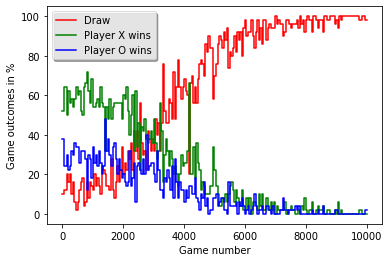

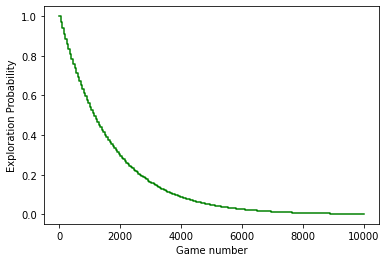

playerX_wins : [52.0, 52.0, 64.0, 64.0, 64.0, 64.0, 50.0, 50.0, 62.0, 62.0, 56.0, 56.0, 58.0, 58.0, 54.0, 54.0, 58.0, 58.0, 64.0, 64.0, 60.0, 60.0, 62.0, 62.0, 52.0, 52.0, 50.0, 50.0, 64.0, 64.0, 66.0, 66.0, 72.0, 72.0, 62.0, 62.0, 56.0, 56.0, 68.0, 68.0, 54.0, 54.0, 54.0, 54.0, 56.0, 56.0, 58.0, 58.0, 54.0, 54.0, 64.0, 64.0, 56.0, 56.0, 54.0, 54.0, 32.0, 32.0, 54.0, 54.0, 48.0, 48.0, 58.0, 58.0, 48.0, 48.0, 54.0, 54.0, 56.0, 56.0, 56.0, 56.0, 56.0, 56.0, 56.0, 56.0, 56.0, 56.0, 48.0, 48.0, 60.0, 60.0, 58.0, 58.0, 64.0, 64.0, 52.0, 52.0, 40.0, 40.0, 50.0, 50.0, 60.0, 60.0, 32.0, 32.0, 62.0, 62.0, 34.0, 34.0, 46.0, 46.0, 22.0, 22.0, 44.0, 44.0, 42.0, 42.0, 48.0, 48.0, 38.0, 38.0, 36.0, 36.0, 38.0, 38.0, 42.0, 42.0, 36.0, 36.0, 48.0, 48.0, 36.0, 36.0, 28.0, 28.0, 32.0, 32.0, 56.0, 56.0, 42.0, 42.0, 16.0, 16.0, 30.0, 30.0, 38.0, 38.0, 32.0, 32.0, 24.0, 24.0, 32.0, 32.0, 28.0, 28.0, 20.0, 20.0, 24.0, 24.0, 20.0, 20.0, 14.0, 14.0, 20.0, 20.0, 30.0, 30.0, 24.0, 24.0, 26.0, 26.0, 26.0, 26.0, 

In [240]:
# Epsilon-greedy 
EXPLORATION_PROBABILITY = 1.0 

# Initialise players
playerX = Agent(Board.playerX, EXPLORATION_PROBABILITY)
playerO = Agent(Board.playerO, EXPLORATION_PROBABILITY)

NUM_SETS = 200
NUM_GAMES_PER_SET = 50

simulate(playerX, playerO, NUM_SETS, NUM_GAMES_PER_SET)
# to Test how the policy and backpropagation logic is working for just one game 
# simulate(playerX, playerO, 1, 1)
# simulate(playerX, playerO, 20, 2)

# Player X's policy

In [241]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [242]:
playerX.policy_trainer.Q

{'[0 0 0 0 0 0 0 0 0]': array([0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]),
 '[ 0  0  0 -1  0  0  1  0  0]': array([0.00, 0.07, 0.09, -2.00, 0.09, 0.09, -2.00, 0.09, 0.09]),
 '[-1  0  0 -1  0  0  1  0  1]': array([-2.00, 0.95, 0.00, -2.00, 0.00, 0.18, -2.00, 0.00, -2.00]),
 '[-1  0  0 -1 -1  1  1  0  1]': array([-2.00, 0.00, 1.00, -2.00, -2.00, -2.00, -2.00, 0.00, -2.00]),
 '[ 0 -1  0  0  0  1  0  0  0]': array([0.70, -2.00, 0.17, 0.72, 0.88, -2.00, 0.00, 0.21, 0.15]),
 '[ 1 -1  0  0  0  1 -1  0  0]': array([-2.00, -2.00, 0.00, 0.00, 0.00, -2.00, -2.00, 0.00, 0.85]),
 '[ 1 -1  0  0  0  1 -1 -1  1]': array([-2.00, -2.00, 1.00, 0.00, 0.00, -2.00, -2.00, -2.00, -2.00]),
 '[ 0  0  0 -1  0  0  0  1  0]': array([0.63, 0.94, 0.21, -2.00, 0.14, 0.14, 0.20, -2.00, 0.63]),
 '[ 0  0  0 -1  1 -1  0  1  0]': array([0.00, 1.00, 0.00, -2.00, -2.00, -2.00, 0.85, -2.00, 0.00]),
 '[ 0  0  0 -1  1 -1  1  1 -1]': array([0.00, 1.00, 0.00, -2.00, -2.00, -2.00, -2.00, -2.00, -2.00]),
 '[ 1  0  0  

# Player O's policy

In [243]:
playerO.policy_trainer.Q

{'[0 0 0 0 0 0 1 0 0]': array([0.00, 0.00, 0.00, 0.09, 0.09, 0.00, -2.00, 0.01, 0.00]),
 '[ 0  0  0 -1  0  0  1  0  1]': array([0.01, -1.00, 0.00, -2.00, -1.00, -1.00, -2.00, 0.09, -2.00]),
 '[-1  0  0 -1  0  1  1  0  1]': array([-2.00, -1.00, 0.00, -2.00, -1.00, -2.00, -2.00, 0.09, -2.00]),
 '[0 0 0 0 0 1 0 0 0]': array([0.02, 0.01, 0.00, 0.00, 0.09, -2.00, 0.01, 0.07, 0.08]),
 '[ 1 -1  0  0  0  1  0  0  0]': array([-2.00, -2.00, 0.00, 0.00, 0.75, -2.00, 0.00, 0.00, 0.00]),
 '[ 1 -1  0  0  0  1 -1  0  1]': array([-2.00, -2.00, -1.00, -0.10, 0.94, -2.00, -2.00, -1.00, -2.00]),
 '[0 0 0 0 0 0 0 1 0]': array([0.01, 0.00, 0.08, 0.00, 0.01, 0.08, 0.09, -2.00, 0.09]),
 '[ 0  0  0 -1  1  0  0  1  0]': array([0.00, 0.00, 0.00, -2.00, -2.00, 0.00, 0.07, -2.00, 0.00]),
 '[ 0  0  0 -1  1 -1  1  1  0]': array([0.00, 0.00, 0.00, -2.00, -2.00, -2.00, -2.00, -2.00, -1.00]),
 '[1 0 0 0 0 0 0 0 0]': array([-2.00, 0.09, 0.09, 0.09, 0.09, 0.08, 0.02, 0.00, 0.02]),
 '[ 1  0  0  0 -1  0  1  0  0]': array(

# Key Learnings


This one task taught me a lot about the nuanced aspects of Q-learning. 

1.   Using Self-Play to improve the Policy towards the Nash Equilibrium. 
2.   Understanding the various twists when implementing Action Value function ie state & action cross product. Like, the importance of eliminating the value of illegal positions in the Q-table so that it does not contribute to the q-value calculation.
3.   For both the winning and losing players, remember to back-propagate the q-value to all intermediate states that contributed to receiving the rewards.
4.   For epsilon-greedy, running sets of episodes and decaying epsilon only for each set to allow for the right amount of exploration/exploitation.
5.   When decaying, consider the hand in glove relationship between epsilon and the number of sets. 
6.   Decay epsilon to low values so that enough sets are executed such that Nash equillibrium can be reached and from then on we do miniscule explorations. 
7.   Remember, for tic tac toe how if you do explorations in later cycles of self-play it can fluctuate the policy.. This is because once you get an optimal policy then doing an exploration is like choosing a non-optimal action and so is like making a mistake... and so this mistake causes the other player to win. 

**Metrics**

Importantly, it gave me a view of the metrics to use to understand the back propagation and way the q-values changed for eg. 
- by looking at the markov chains for the top level state of the board (0 0 0 0 0 0) you can see how the policy shapes up and where it settles to optimal one which leads to more draws.
- Run the simulations 1 to 2 games at a time to see how the policy is tuned. 
- Start with a pre-set legal state of the board and see how simulation runs from there to get the q-table. 

All in all, a roller coaster but satisfatory project. This has given me the insights to help solve the problem that I originally was looking to solve when I started on this jojurney of learning RL. 
